In [17]:
import datajoint as dj

# from aeon.dj_pipeline import acquisition, lab, tracking, analysis, report, qc
from aeon.dj_pipeline.report import *
# acquisition.SubjectEnterExit()
# InArenaSummaryPlot.progress()
# InArenaSummaryPlot.populate(limit=1)
# %%
key_id = 10
key = (analysis.InArena * analysis.InArenaEnd).fetch('KEY')[key_id]
in_arena_start, in_arena_end = (
    analysis.InArena * analysis.InArenaEnd & key
).fetch1("in_arena_start", "in_arena_end")

print(key)
print(in_arena_start)
print(in_arena_end)


{'experiment_name': 'exp0.1-r0', 'subject': 'BAA-1099790', 'in_arena_start': datetime.datetime(2021, 6, 29, 13, 6, 34, 761660)}
2021-06-29 13:06:34.761660
2021-06-29 17:11:26.405819


In [18]:
# subject's position data in the time_slices
position = analysis.InArenaSubjectPosition.get_position(key)
position.rename(columns={"position_x": "x", "position_y": "y"}, inplace=True)
position_minutes_elapsed = (
    position.index - in_arena_start
).total_seconds() / 60

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


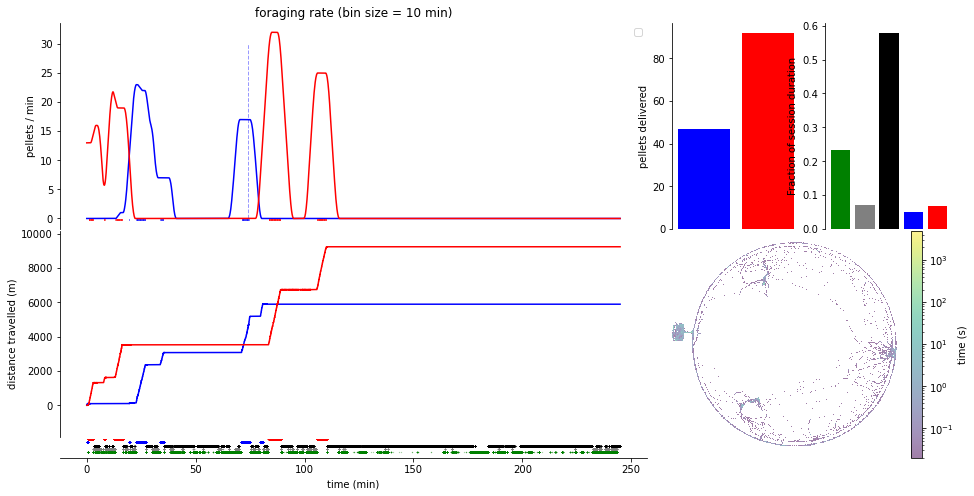

In [20]:

# figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(21, 6)
rate_ax = fig.add_subplot(gs[:10, :4])
distance_ax = fig.add_subplot(gs[10:20, :4])
ethogram_ax = fig.add_subplot(gs[20, :4])
position_ax = fig.add_subplot(gs[10:, 4:])
pellet_ax = fig.add_subplot(gs[:10, 4])
time_dist_ax = fig.add_subplot(gs[:10, 5:])

# position plot
non_nan = np.logical_and(~np.isnan(position.x), ~np.isnan(position.y))
analysis_plotting.heatmap(
    position[non_nan], 50, ax=position_ax, bins=500, alpha=0.5
)

# event rate plots
in_arena_food_patches = (
    analysis.InArena
    * acquisition.ExperimentFoodPatch.join(
        acquisition.ExperimentFoodPatch.RemovalTime, left=True
    )
    & key
    & "in_arena_start >= food_patch_install_time"
    & 'in_arena_start < IFNULL(food_patch_remove_time, "2200-01-01")'
).proj("food_patch_description")

for food_patch_key in in_arena_food_patches.fetch(as_dict=True):
    pellet_times_df = (
        (
            acquisition.FoodPatchEvent * acquisition.EventType
            & food_patch_key
            & 'event_type = "TriggerPellet"'
            & f'event_time BETWEEN "{in_arena_start}" AND "{in_arena_end}"'
        )
        .proj("event_time")
        .fetch(format="frame", order_by="event_time")
        .reset_index()
    )
    pellet_times_df.set_index("event_time", inplace=True)
    analysis_plotting.rateplot(
        pellet_times_df,
        window="600s",
        frequency=500,
        ax=rate_ax,
        smooth="120s",
        start=in_arena_start,
        end=in_arena_end,
        color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]],
    )
    
    # mark threshold changes
    wheel_time, wheel_threshold = (acquisition.WheelState.Time & 
            food_patch_key & 
            f'state_timestamp between "{in_arena_start}" and "{in_arena_end}"').fetch('state_timestamp', 'threshold')
    wheel_time -= in_arena_start 
    wheel_time /= datetime.timedelta(minutes=1)
    
    
    threshold_change_ind = np.where(wheel_threshold[:-1] != wheel_threshold[1:])[0]
    # rate_ax.vlines(wheel_time[threshold_change_ind], 0, rate_ax.get_ylim()[1], linewidth=1, linestyle='--', 
    #                color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]], alpha=0.2)
    rate_ax.vlines(wheel_time[threshold_change_ind], 0, 30, linewidth=1, linestyle='--', 
                   color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]], alpha=0.4)
    
    # wheel data
    wheel_data = acquisition.FoodPatchWheel.get_wheel_data(
        experiment_name=key["experiment_name"],
        start=pd.Timestamp(in_arena_start),
        end=pd.Timestamp(in_arena_end),
        patch_name=food_patch_key["food_patch_description"],
        using_aeon_io=True,
    )

    minutes_elapsed = (wheel_data.index - in_arena_start).total_seconds() / 60
    distance_ax.plot(
        minutes_elapsed,
        wheel_data.distance_travelled.values,
        color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]],
    )

# ethogram
in_arena, in_corridor, arena_time, corridor_time = (
    analysis.InArenaTimeDistribution & key
).fetch1(
    "in_arena",
    "in_corridor",
    "time_fraction_in_arena",
    "time_fraction_in_corridor",
)
nest_keys, in_nests, nests_times = (
    analysis.InArenaTimeDistribution.Nest & key
).fetch("KEY", "in_nest", "time_fraction_in_nest")
patch_names, in_patches, patches_times = (
    analysis.InArenaTimeDistribution.FoodPatch * acquisition.ExperimentFoodPatch
    & key
).fetch("food_patch_description", "in_patch", "time_fraction_in_patch")

ethogram_ax.plot(
    position_minutes_elapsed[in_arena],
    np.full_like(position_minutes_elapsed[in_arena], 0),
    ".",
    color=InArenaSummaryPlot.color_code["arena"],
    markersize=0.5,
    alpha=0.6,
    label=f"Times in arena",
)
ethogram_ax.plot(
    position_minutes_elapsed[in_corridor],
    np.full_like(position_minutes_elapsed[in_corridor], 1),
    ".",
    color=InArenaSummaryPlot.color_code["corridor"],
    markersize=0.5,
    alpha=0.6,
    label=f"Times in corridor",
)
for in_nest in in_nests:
    ethogram_ax.plot(
        position_minutes_elapsed[in_nest],
        np.full_like(position_minutes_elapsed[in_nest], 2),
        ".",
        color=InArenaSummaryPlot.color_code["nest"],
        markersize=0.5,
        alpha=0.6,
        label=f"Times in nest",
    )
for patch_idx, (patch_name, in_patch) in enumerate(
    zip(patch_names, in_patches)
):
    ethogram_ax.plot(
        position_minutes_elapsed[in_patch],
        np.full_like(position_minutes_elapsed[in_patch], (patch_idx + 3)),
        ".",
        color=InArenaSummaryPlot.color_code[patch_name],
        markersize=0.5,
        alpha=0.6,
        label=f"Times in {patch_name}",
    )

# pellet
patch_names, patches_pellet = (
    analysis.InArenaSummary.FoodPatch * acquisition.ExperimentFoodPatch & key
).fetch("food_patch_description", "pellet_count")
pellet_ax.bar(
    range(len(patches_pellet)),
    patches_pellet,
    color=[InArenaSummaryPlot.color_code[n] for n in patch_names],
)

# time distribution
time_fractions = [arena_time, corridor_time]
colors = [InArenaSummaryPlot.color_code["arena"], InArenaSummaryPlot.color_code["corridor"]]
time_fractions.extend(nests_times)
colors.extend([InArenaSummaryPlot.color_code["nest"] for _ in nests_times])
time_fractions.extend(patches_times)
colors.extend([InArenaSummaryPlot.color_code[n] for n in patch_names])
time_dist_ax.bar(range(len(time_fractions)), time_fractions, color=colors)

# cosmetic
rate_ax.legend()
rate_ax.sharex(distance_ax)
fig.subplots_adjust(hspace=0.1)
rate_ax.set_ylabel("pellets / min")
rate_ax.set_title("foraging rate (bin size = 10 min)")
distance_ax.set_ylabel("distance travelled (m)")
ethogram_ax.set_xlabel("time (min)")
analysis_plotting.set_ymargin(distance_ax, 0.2, 0.1)
for ax in (rate_ax, distance_ax, pellet_ax, time_dist_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)

ethogram_ax.spines["top"].set_visible(False)
ethogram_ax.spines["right"].set_visible(False)
ethogram_ax.spines["left"].set_visible(False)
ethogram_ax.tick_params(left=False, labelleft=False)
analysis_plotting.set_ymargin(ethogram_ax, 0.4, 0)

position_ax.set_aspect("equal")
position_ax.set_axis_off()

pellet_ax.set_ylabel("pellets delivered")
time_dist_ax.set_ylabel("Fraction of session duration")

fig.show()
